# Schnorr

In our previous problem, the Prover tried to convince the Verifier of its knowledge of a graph three coloring.

Now, the Prover claims that it knows a secret key that belongs to a given public key.

A secret key is the discrete logarithm of the public key. The secret key is a scalar and the public key is a curve point.

# The protocol

Like before, the Verifier **challenges** the Prover. The Verifier accepts if the Prover **responds** in a satisfactory manner, indicating that it knows the secret key.

Before that, the Prover makes a cryptographic **commitment**. This is like a black box that is opaque for the Verifier, but the Prover cannot change its contents without the Verifier noticing.

This commitment is also called the public **nonce**, and it includes the secret nonce. The nonce hides the secret key in the Prover's response. Without hiding, the Verifier could easily extract the secret key. This process is similar to the random color mappings from before, but we didn't need a commitment for that.

To summarize, there are three steps:

1. Commitment
2. Challenge
3. Response

_Protocols with these three steps are called "Sigma protocols"._

# Scary math

If you can stand some math, here is the protocol in more detail. **Feel free to skip.**

At the start of the protocol, the public key $P$ is known to all parties.

1. Prover generates random scalar $k$ _(secret nonce)_ and computes point $R = k * G$ _(public nonce)_
2. Prover sends $R$ to Verifier **(commitment)**
3. Verifier generate random scalar $e$ **(challenge)** and sends it to Prover
4. Prover computes $s = k + e * x$ **(response)** and sends it to Prover
5. Verifier checks if $s * G \overset{?}{=} R + e * P$ holds

# Implementation

Here is an implementation in Python.

**Don't stress over the details.** You don't have to understand why everything is there.

Instead, let's focus on the flow of values from method to method.

There is a public key. The Prover sends a commitment to the Verifier. The Verifier sends a challenge to the Prover. The Prover meets this challenge by responding to the Verifier. The Verifier verifies the response.

In [24]:
from utils.curve import *

class SchnorrProver:
    def __init__(self):
        self.x = Scalars.random_element()
        
    def pub_key(self):
        P = ZZ(self.x) * One
        return P
    
    def sec_key(self):
        return self.x
        
    def commit(self):
        self.k = Scalars.random_element()
        R = ZZ(self.k) * One
        return R
    
    def respond(self, e):
        s = self.k + e * self.x
        return s

class SchnorrVerifier:
    def __init__(self, P):
        self.P = P
    
    def challenge(self, R):
        self.R = R
        self.e = Scalars.random_element()
        return self.e
    
    def verify(self, s):
        return ZZ(s) * One == self.R + ZZ(self.e) * self.P

## Exercise

Fill in the gaps in the following code to run the Schnorr protocol. Is your Verifier convinced of what the Prover claims?

In [14]:
prover = None  # TODO: Change
verifier = None  # TOOD: Change

P = None  # TODO: Change
print("P = {}".format(P.xy()))

R = None  # TODO: Change
print("R = {}".format(R.xy()))

e = None  # TODO: Change
print("e = {}".format(e))

s = None  # TODO: Change
print("s = {}\n".format(s))

if verifier.verify(s):
    print("Convinced 👌")
else:
    print("Not convinced... 🤨")
    
# Sanity check
x = prover.sec_key()
assert ZZ(x) * One == P

AttributeError: 'NoneType' object has no attribute 'xy'

# Is Schnorr complete?

Does an honest Prover always convince the Verifier?

I claim it is. There is a mathematical proof that I will gloss over. Let's do a fun experiment instead.

## Exercise

Run the following code as often as you want, until you are convinced that Schnorr always works. Feel free to randomize the Prover, too.

In [10]:
# Put these two lines into the loop body to randomize the Prover as well
prover = SchnorrProver()
P = prover.pub_key()

for _ in range(0, None):  # TODO: Change
    # Put the two lines below here
    
    verifier = SchnorrVerifier(P)
    R = prover.commit()
    e = verifier.challenge(R)
    s = prover.respond(e)
    
    if not verifier.verify(s):
        print("Oh oh! 😳")
        break

print("Convinced yet? 😏")

Convinced yet? 😏


# Is Schnorr sound?

Is a vigilant Verifier safe from being convinced by a hishonest Prover?

Does the Prover need to know the secret key for it to convince the Verifier?

Yes to both questions. Check out this extraction algorithm.

## Secret key extraction

Recall that if we can extract the secret from the Prover, then the Prover must know it.

1. Run the prover until it commits to $R$
2. Copy the prover and rename into prover1 and prover2
3. Send challenge $e_1$ to prover1
4. Send different challenge $e_2$ to prover2
5. Receive response $s_1$ from prover1
6. Receive response $s_2$ from prover2
7. Compute $x = \frac{s_1 - s_2}{e_1 - e_2}$

In [44]:
import copy

def extractor(prover):
    # Run protocol until prover commits
    P = prover.pub_key()
    verifier = Verifier(P)
    R = prover.commit()
    
    # Copy prover into prover1 and prover2
    prover1 = copy.copy(prover)
    prover2 = copy.copy(prover)
    
    # Challenge both provers with different challenges
    e1 = verifier.challenge(R)
    e2 = e1
    while e1 == e2:
        e2 = verifier.challenge(R)
    
    # Get both provers' responses
    s1 = prover1.respond(e1)
    s2 = prover2.respond(e2)
    
    # Extract the private key using the above formula
    extracted_x = (s1 - s2) / (e1 - e2)
    return extracted_x


# Let's see the extractor in action
prover = Prover()
extracted_x = extractor(prover)
print("extracted x = {}\n".format(extracted_x))

# Sanity check
x = prover.sec_key()
if x == extracted_x:
    print("Extraction successful 😈")
else:
    print("I didn't believe in this extraction business from the get-go 🤨")

extracted x = 685

Extraction successful 😈


## Exercise

Convince yourself that the extraction always works by running the following loop as many times as you want.

In [12]:
for _ in range(0, None):  # TODO: Change
    prover = Prover()
    extracted_x = extractor(prover)
    x = prover.sec_key()
    
    if x != extracted_x:
        print("Oh oh! 😳")
        break

print("Convinced yet? 😏")

TypeError: 'NoneType' object cannot be interpreted as an integer

# Is Schnorr zero-knowledge?

Does the Prover reveal any information about its secret key? After all, the signature is _some_ kind of information; it contains bits.

I claim there is no leakage. Let's find out in another experiment.

## Exercise

Run the following code for some number of iterations to get a feeling for the real transcript distribution.

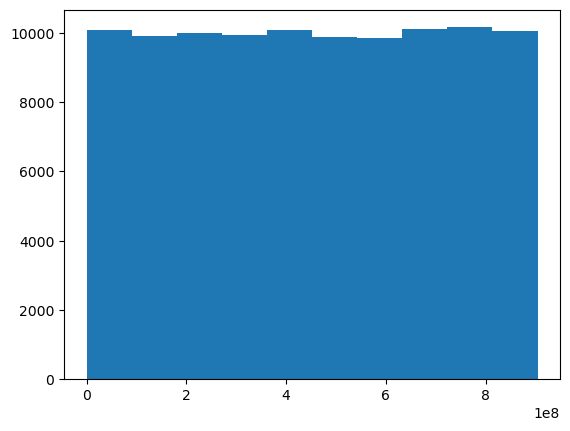

In [22]:
import matplotlib.pyplot as plt

prover = SchnorrProver()
P = prover.pub_key()

def real_transcript():
    verifier = SchnorrVerifier(P)
    R = prover.commit()
    e = verifier.challenge(R)
    s = prover.respond(e)
    return (R, e, s)

def compress(R, e, s):
    R_prime = int(One.discrete_log(R)) * number_points ** 2
    e_prime = int(e) * number_points
    s_prime = int(s)
    return R_prime + e_prime + s_prime

real_data = []

for _ in range(0, None):  # TODO: Change
    real_data.append(compress(*real_transcript()))
    
plt.hist(real_data)
plt.show()

## Exercise

Now run the following code to get a feeling for the fake distribution. This code knows nothing about the secret key. It generates two random elements and chooses a third element based on the first two. Compare with the real distribution.

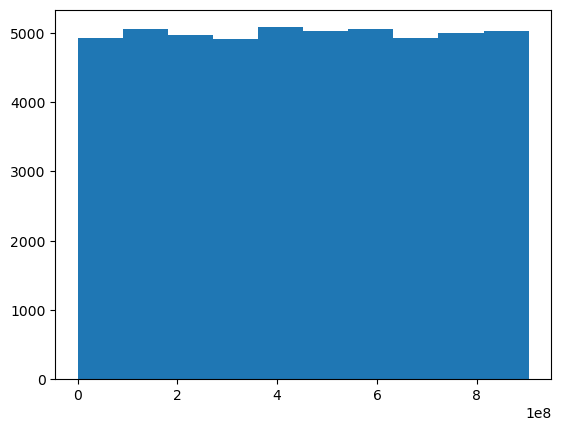

In [23]:
def fake_transcript():
    e = Scalars.random_element()
    s = Scalars.random_element()
    R = s * One - e * P
    return (R, e, s)

fake_data = []

for _ in range(0, None):  # TODO: Change
    fake_data.append(compress(*fake_transcript()))
    
plt.hist(fake_data)
plt.show()